# Overview
This notebook performs time-series analysis on Independence, MO, USA's historical temperatures, sourced from the Berkeley Earth dataset on Kaggle. 

# Link
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

# Plan
1. Download the data to local machine
2. Split out Independence's data from the other data, export to CSV
3. Check overall historical temperature change over time
4. Split data into train, validate, and test appropriate for recent (more-representative) measurements
5. Explore seasonality and resampling strategies
6. Choose a seasonality and resampling for modeling
7. Push the reformatted data to a few time-series models
8. Evaluate RMSE on validate, compare performance between models
9. Select best model, run model on test
10. Report results, conclude analysis
11. Make predictions for 2010-2030 temperatures using the best model

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as sm

from sklearn.metrics import mean_squared_error
from math import sqrt

# Wrangle
Step #1, Step #2

In [2]:
# Step #1, Step #2: acquire data
# df = pd.read_csv('archive/GlobalLandTemperaturesByCity.csv')
# df[df.City == 'Independence'].reset_index().to_csv('independence_temps.csv')

Step #3

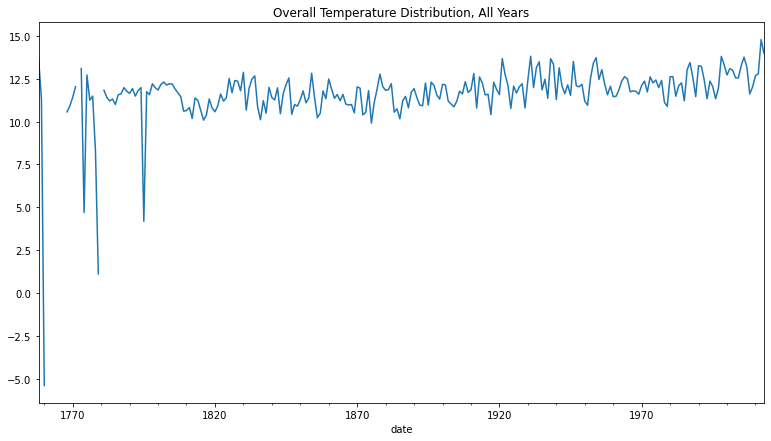

In [3]:
# Step #3: tidy up data
df = pd.read_csv('independence_temps.csv', index_col=0) # read data
df['date'] = df['dt'].astype('datetime64') # change to datetime64 dtype
df.index = df['date'] # assign to index
df = df.drop(columns='dt') # drop value column
df['AverageTemperature'].resample('Y').mean().plot(figsize=(13,7),
                                                   title='Overall Temperature Distribution, All Years') # data is in months, plot by year
plt.show()

# Split
Step #4

In [4]:
# Step #4: prepare data
df = df[['AverageTemperature']][(df.index.year >= 1910) & (df.index.year < 2010)] # analyze 1910 - 2009 (100 years)
train = df[df.index.year < 1970] # first 60 years
validate = df[(df.index.year >= 1970) & (df.index.year < 1990)] # next 20 years
test = df[df.index.year >= 1990] # last 20 years
len(train) + len(validate) + len(test) == len(df) # check if done correctly

True

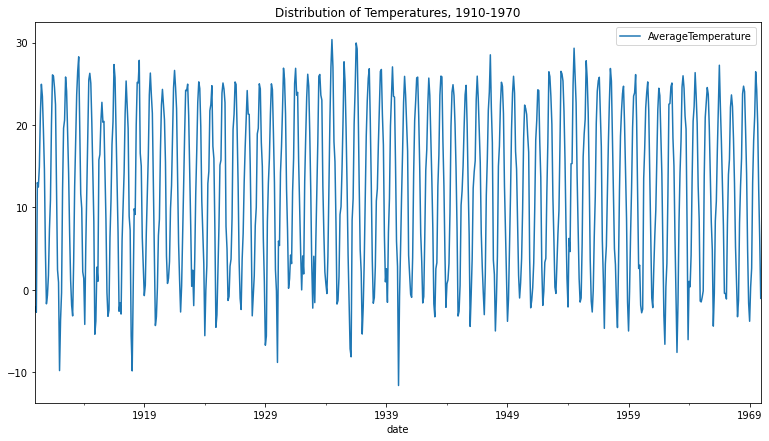

In [5]:
train.plot(figsize=(13,7))
plt.title('Distribution of Temperatures, 1910-1970')
plt.show()

# Explore
Step #5
## Resample

In [6]:
# resample monthly data into quarterly, semi-annual, annual, and tri-annual
quarterly_df = train.resample('3M').mean()
semi_annual_df = train.resample('6M').mean()
annual_df = train.resample('Y').mean()
tri_annual_df = train.resample('3Y').mean()

## Plot Resampled Data

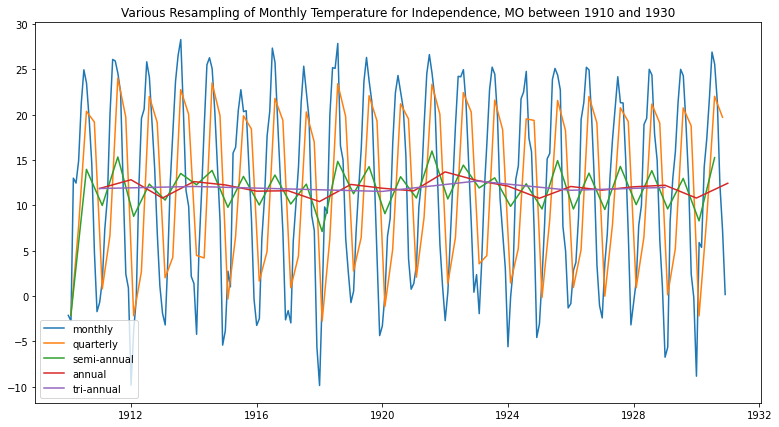

In [7]:
# plot a subset of train (1910-1930) to check work
plt.figure(figsize=(13,7))
plt.plot(train['1910':'1930'], label='monthly')
plt.plot(quarterly_df['1910':'1930'], label='quarterly')
plt.plot(semi_annual_df['1910':'1930'], label='semi-annual')
plt.plot(annual_df['1910':'1930'], label='annual')
plt.plot(tri_annual_df['1910':'1930'], label='tri-annual')
plt.title('Various Resampling of Monthly Temperature for Independence, MO between 1910 and 1930')
plt.legend()
plt.show()

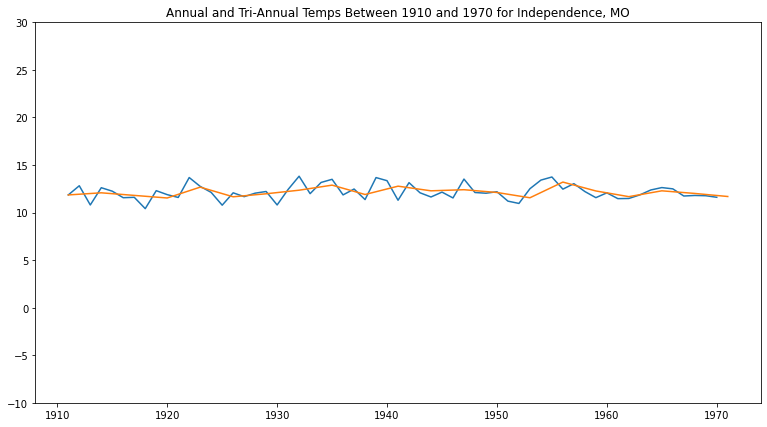

In [8]:
# plot all of train in annual and tri-annual resamples
plt.figure(figsize=(13,7))
plt.plot(annual_df)
plt.plot(tri_annual_df)
plt.yticks([-10,-5,0,5,10,15,20,25,30])
plt.title('Annual and Tri-Annual Temps Between 1910 and 1970 for Independence, MO')
plt.show()

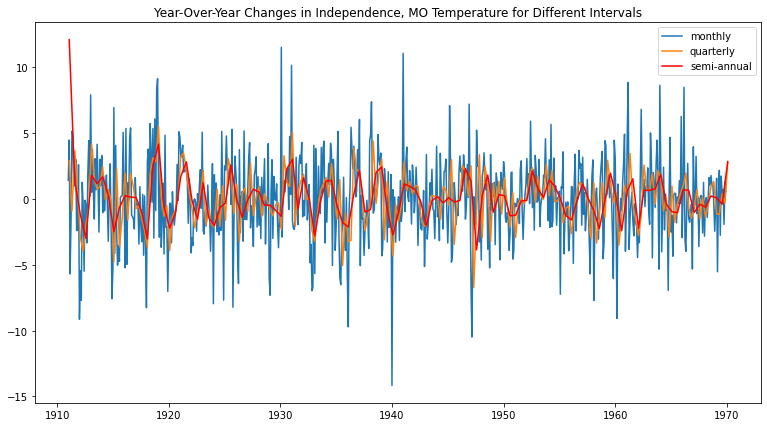

In [9]:
# create .diff columns for year-over-year changes
train['yoy'] = train.AverageTemperature.diff(12)
quarterly_df['yoy'] = quarterly_df.AverageTemperature.diff(4)
semi_annual_df['yoy'] = semi_annual_df.AverageTemperature.diff(2)

# plot year-over-year changes (lag plot)
plt.figure(figsize=(13,7))
plt.plot(train.yoy, label='monthly')
plt.plot(quarterly_df.yoy, label='quarterly')
plt.plot(semi_annual_df.yoy, label='semi-annual', c='red')
plt.title('Year-Over-Year Changes in Independence, MO Temperature for Different Intervals')
plt.legend()
plt.show()

# drop columns back out
train.drop(columns='yoy', inplace=True)
quarterly_df.drop(columns='yoy', inplace=True)
semi_annual_df.drop(columns='yoy', inplace=True)

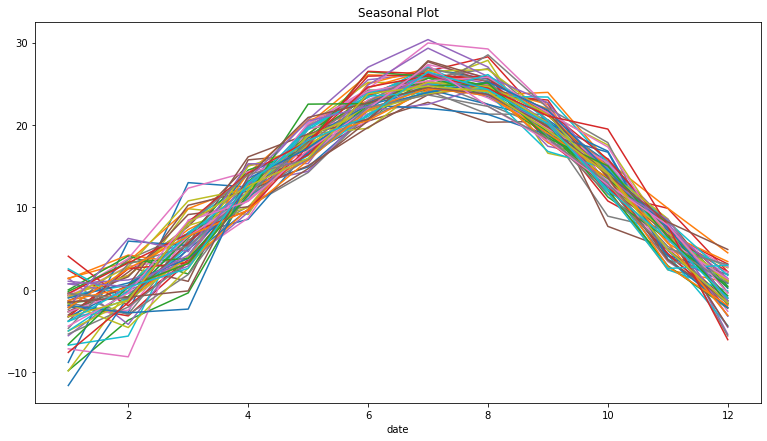

In [10]:
# plot seasonal difference
train.groupby([train.index.year, train.index.month]).mean().unstack(0)\
.plot(title='Seasonal Plot', legend=None, figsize=(13,7))
plt.show()

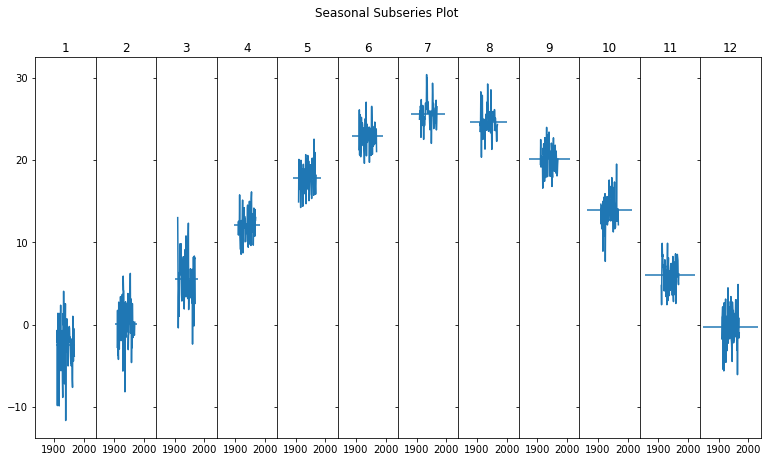

In [11]:
# plot seasonal subseries
table = train.groupby([train.index.year, train.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month[1])
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.set_figheight(7)
fig.set_figwidth(13)
fig.suptitle('Seasonal Subseries Plot')
fig.subplots_adjust(wspace=0)

## Takeaways
Step #6

From the data, temperature is highly seasonal, in each year it trends up heading from winter to summer and trends down from summer to winter. Because of this, I'm choosing to retain the monthly sample, and I believe that the Previous-Cycle model will perform best.

# Model
Step #7

In [12]:
# Model: Last-Observed Value
validate['last_value'] = train.tail(1).AverageTemperature[0]

In [13]:
# Model: Simple Average
validate['simple_average'] = train.AverageTemperature.mean()

In [14]:
# Model: Running Average
validate['yearly_running_average'] = train.AverageTemperature.rolling(12).mean()[-1]

In [15]:
# Model: Holt's Linear Trend
model = sm.Holt(train['AverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)
validate['Holt_0.1_0.1'] = model.predict(start = validate.index[0], 
                                       end = validate.index[-1])

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [16]:
# Model: Previous Cycle
mean_monthly_yoy = train.AverageTemperature.diff(12).mean()
validate['previous_cycle_yoy'] = list(train['1950':].AverageTemperature)
validate['previous_cycle_yoy'] = validate['previous_cycle_yoy'] + mean_monthly_yoy

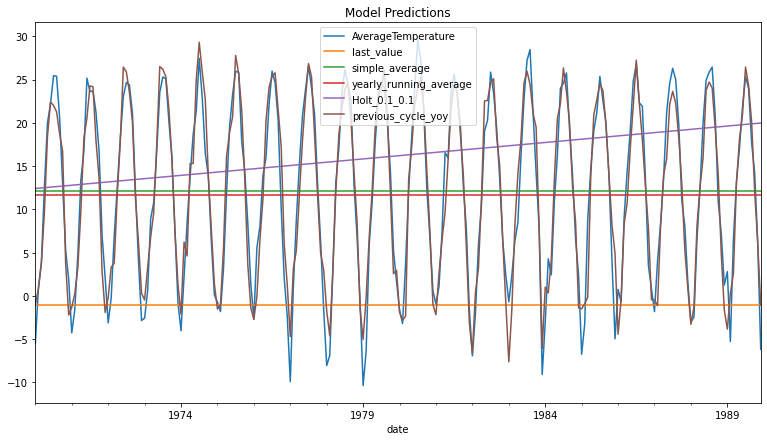

In [17]:
validate.plot(figsize=(13,7))
plt.title('Model Predictions')
plt.show()

Step #8

In [18]:
# evaluate RMSE
for col in validate.columns[1:]:
    RMSE = round(sqrt(mean_squared_error(validate['AverageTemperature'], validate[col])), 0)
    print(col + ' RMSE:\n' + str(RMSE) + ' degrees\n')

last_value RMSE:
17.0 degrees

simple_average RMSE:
10.0 degrees

yearly_running_average RMSE:
10.0 degrees

Holt_0.1_0.1 RMSE:
11.0 degrees

previous_cycle_yoy RMSE:
3.0 degrees



Step #9

The best performing model is Previous Cycle with an RMSE of 3 degrees. We will now evaluate this model on the test split.

In [19]:
# apply predictions to test
test['best_model'] = list(train['1950':].AverageTemperature)
test['best_model'] = test['best_model'] + mean_monthly_yoy

In [20]:
# calculate RMSE
RMSE = round(sqrt(mean_squared_error(test['AverageTemperature'], test['best_model'])), 0)
print('Best model RMSE:', RMSE, 'degrees')

Best model RMSE: 3.0 degrees


## Modeling Results
Step #10

For this dataset, **Previous Cycle performed best** with an RMSE of 3.0 degrees on both out-of-sample splits.

# Predicting the Future
Step #11

Since the best-performing model was Previous Cycle, we simply **use the temperature data of 1950-1970 to predict the temperature of years 2010-2030.**